In [1]:
import shapely
import geopandas as gpd
import numpy as np
import pandas as pd
import pathlib
import rasterio
import cv2
import xarray as xr
import scipy

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches

from matplotlib.colors import LightSource

In [2]:
data_dir = pathlib.Path("~/data/vcl/dataset").expanduser()

In [3]:
extent = gpd.read_file(data_dir / "bounding_box.shp").to_crs(epsg=28992).iloc[0].geometry

ds = xr.open_dataset(data_dir / "concentratie_data_gw_model.nc")
ds_b0 = rasterio.open(data_dir / "originele_bodem.tif")

In [4]:
# Get vertices of geometry (rectangle)
coords = list(extent.exterior.coords)
coords = pd.DataFrame(coords)
coords.columns = ["x", "y"]

# Get minimum and maximum x and y values from vertices
xmin = coords.idxmin(0)["x"]
ymin = coords.idxmin(0)["y"]
xmax = coords.idxmax(0)["x"]
ymax = coords.idxmax(0)["y"]

# Find bottom left point and bottom right point of original extent
bottom_point = [coords.iloc[ymin]["x"], coords.iloc[ymin]["y"]]
right_point = [coords.iloc[xmax]["x"], coords.iloc[xmax]["y"]]

# Compute the rotation angle of original extent
o = right_point[1] - bottom_point[1]
a = right_point[0] - bottom_point[0]

angle = np.rad2deg(np.arctan(o / a))

# Get center point of extent
mid_point = extent.centroid.coords[0]

In [5]:
# Get plot lims of rotated extent (rotated such that extent has an angle of 0 with the horizontal axis)
rotated_extent = shapely.affinity.rotate(extent, -angle)

plt_lims = rotated_extent.exterior.bounds

In [6]:
conc_bounds = (
    ds.conc.x.values[0],
    ds.conc.y.values[-1],
    ds.conc.x.values[-1],
    ds.conc.y.values[0],
)

dummy = scipy.ndimage.rotate(ds.conc.values[0, ...], -angle, reshape=True, order=0, cval=np.nan)
rot_ds = np.zeros((ds.conc.shape[0], dummy.shape[0], dummy.shape[1]))

for i in range(rot_ds.shape[0]):
    rot_ds[i, ...] = scipy.ndimage.rotate(
        ds.conc.values[i, ...], -angle, reshape=True, order=0, cval=np.nan
    )

In [7]:
def get_rotated_vertex(center, point, angle):
    """
    Computes new coordinates of a rectangle vertex after rotation

    Input:
        - center, the center point of the rectangle
        - point, the original vertex point
        - angle, the rotation angle of the rectangle

    Output:
        - rotated_point, the new coordinates of point after rotation
    """
    # Translate point such that 'rectangle' has center at (0, 0)
    new_point = np.array(point) - np.array(center)
    # Create rotation matrix
    rot_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    # Compute rotated point
    rotated_point = np.matmul(rot_matrix, new_point)
    # translate point back
    rotated_point = rotated_point + np.array(center)
    return rotated_point

def fit_array_to_bounds(array, array_bounds, center, extent, angle):
    """
    Crops the array to the extent. This assumes that array is rotated by angle degrees
    and extent is the extent after rotation. array bounds are the original bounds before rotation

    Input:
        - array, a 'rotated' array which we want to crop
        - array_bounds, the bounds or extent of the original array before rotation
        - center, the center point of the extent to which we want to crop
        - extent, the extent to which we want to crop
        - angle, the rotation angle of the array

    Output:
        - array, the cropped array
        - dx, the distance one cell in x direction represents
        - dy, the distance one cell in y direction represents
    """
    left, bottom, right, top = array_bounds

    # Compute new vertex positions after rotation
    xmin1 = get_rotated_vertex(center, (left, bottom), np.deg2rad(angle))[0]
    ymin1 = get_rotated_vertex(center, (right, bottom), np.deg2rad(angle))[1]
    xmax1 = get_rotated_vertex(center, (right, top), np.deg2rad(angle))[0]
    ymax1 = get_rotated_vertex(center, (left, top), np.deg2rad(angle))[1]

    # Get extent of area of interest
    xmin2, ymin2, xmax2, ymax2 = extent

    # Assumes that array dimensions are (y, x) or (z, y, x)
    if len(array.shape) == 2:
        # Compute dx and dy
        dx = np.round((xmax1 - xmin1) / array.shape[1])
        dy = np.round((ymax1 - ymin1) / array.shape[0])

        # Compute bounds (in indices) corresponding to extent
        # Note that ymax1 and ymax2 are the actual coordinate values, therefore the ymin index is computed using ymax coordinates
        xmin = int((xmin2 - xmin1) / dx)
        xmax = int(array.shape[1] - (xmax1 - xmax2) / dx)
        ymin = int((ymax1 - ymax2) / dy)
        ymax = int(array.shape[0] - (ymin2 - ymin1) / dy)

        array = array[ymin:ymax, xmin:xmax]
    elif len(array.shape) == 3:
        # Compute dx and dy
        dx = np.round((xmax1 - xmin1) / array.shape[2])
        dy = np.round((ymax1 - ymin1) / array.shape[1])

        # Compute bounds (in indices) corresponding to extent
        # Note that ymax1 and ymax2 are the actual coordinate values, therefore the ymin index is computed using ymax coordinates
        xmin = int((xmin2 - xmin1) / dx)
        xmax = int(array.shape[2] - (xmax1 - xmax2) / dx)
        ymin = int((ymax1 - ymax2) / dy)
        ymax = int(array.shape[1] - (ymin2 - ymin1) / dy)

        array = array[:, ymin:ymax, xmin:xmax]
    return (array, dx, dy)

In [8]:
(
    conc,
    dx_conc,
    dy_conc,
) = fit_array_to_bounds(
    rot_ds,
    conc_bounds,
    mid_point,
    plt_lims,
    -angle,
)

In [9]:
Y, Z = np.meshgrid(
    np.linspace(
        plt_lims[3],
        plt_lims[1],
        conc.shape[1],
    ),
    ds.z
)

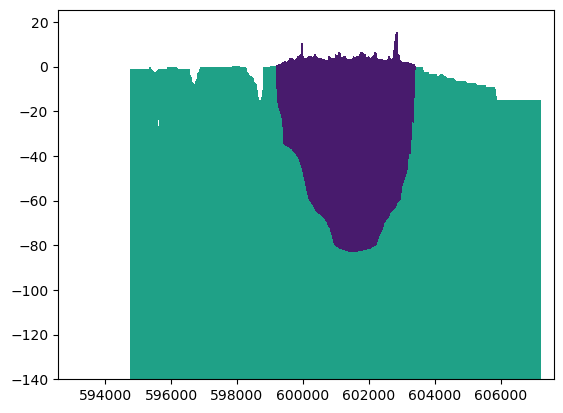

In [10]:
fig, ax = plt.subplots()
ax.contourf(Y, Z, conc[..., 100], levels=[-1, 1.5, 16])

In [11]:
def contourf_to_array(cs, nbpixels_x, nbpixels_y, scale_x, scale_y):
    """
    Draws filled contours from contourf or tricontourf cs on output array of size (nbpixels_x, nbpixels_y)

    Input:
        - cs, a contourf or tricontourf object from matplotlib
        - nbpixles_x, the number of rows for the output arrays
        - nbpixels_y, the number of columns for the output arrays
        - scale_x, the x component of the meshgrid for the contours
        - scale_y, the y component of the meshgrid for the contours

    Output:
        - images, a dictionary of arrays for each contour level
        - shapes, a dictionary of polygons from the contour for each contour level
    """
    image = np.zeros((nbpixels_x, nbpixels_y)) - 10
    images = {}
    shapes = {}

    for i, collection in enumerate(cs.collections):
        z = cs.levels[i]  # get contour levels from cs
        images[i] = np.full((nbpixels_x, nbpixels_y), np.nan)
        for path in collection.get_paths():
            verts = (
                path.to_polygons()
            )  # get vertices of current contour level (is a list of arrays)
            for j, v in enumerate(verts):
                # rescale vertices to image size
                v[:, 0] = (
                    (v[:, 0] - np.min(scale_x))
                    / (np.max(scale_x) - np.min(scale_x))
                    * nbpixels_y
                )
                v[:, 1] = (
                    (v[:, 1] - np.min(scale_y))
                    / (np.max(scale_y) - np.min(scale_y))
                    * nbpixels_x
                )
                poly = np.array(
                    [v], dtype=np.int32
                )  # dtype integer is necessary for the next instruction
                cv2.fillPoly(images[i], poly, z)
                if j == 0:
                    shapes[i] = shapely.Polygon(poly[0, ...])
                    shapes[i] = shapely.MultiPolygon([shapes[i]])
                else:
                    try:
                        shapes[i] = shapes[i].union(shapely.Polygon(poly[0, ...]))
                    except:
                        continue
    return images, shapes


# This function was needed, since otherwise a smaller polygon fully inside a bigger polygon could get overwritten
def combine_polygons(images, shapes):
    """
    Function for combining images containing polygons from contour levels
    into one image in the order of biggest polygons to smallest polygons

    Input:
        - images, a dictionary of arrays for each contour level
        - shapes, a dictionary of polygons from the contour for each contour level

    Output:
        - image, an array combined from images
    """

    # Sort polygons from big to small
    polygons = sorted(shapes.items(), key=lambda item: item[1].area, reverse=True)
    image = np.full(images[0].shape, np.nan)
    # Add polygons from images to image
    for i in polygons:
        image[~np.isnan(images[i[0]])] = np.nanmax(images[i[0]])

    return image

C:\Users\hemert\AppData\Local\Temp\ipykernel_12000\601071678.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for i, collection in enumerate(cs.collections):


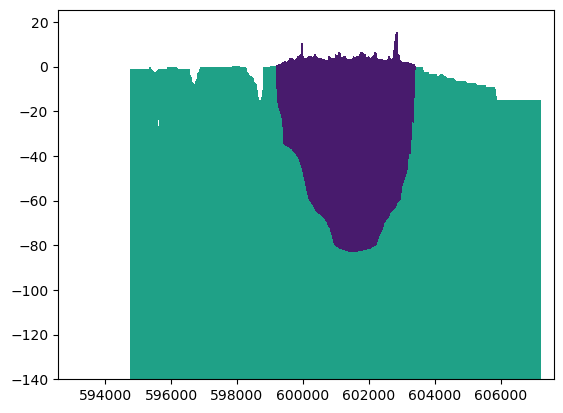

In [12]:
cs = plt.contourf(Y, Z, conc[..., 100], levels=[-1, 1.5, 16])

contourfs, shapes = contourf_to_array(
    cs, 320, conc.shape[1], Y, Z
)

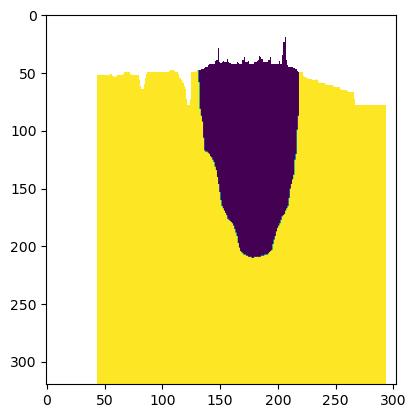

In [13]:
contourf_array = np.flip(combine_polygons(contourfs, shapes), axis=0)
plt.imshow(contourf_array)